In [13]:
from google.colab import files
from IPython.display import Image

In [14]:
uploaded = files.upload()

Saving solo-leveling-3840x2160-19518.png to solo-leveling-3840x2160-19518.png


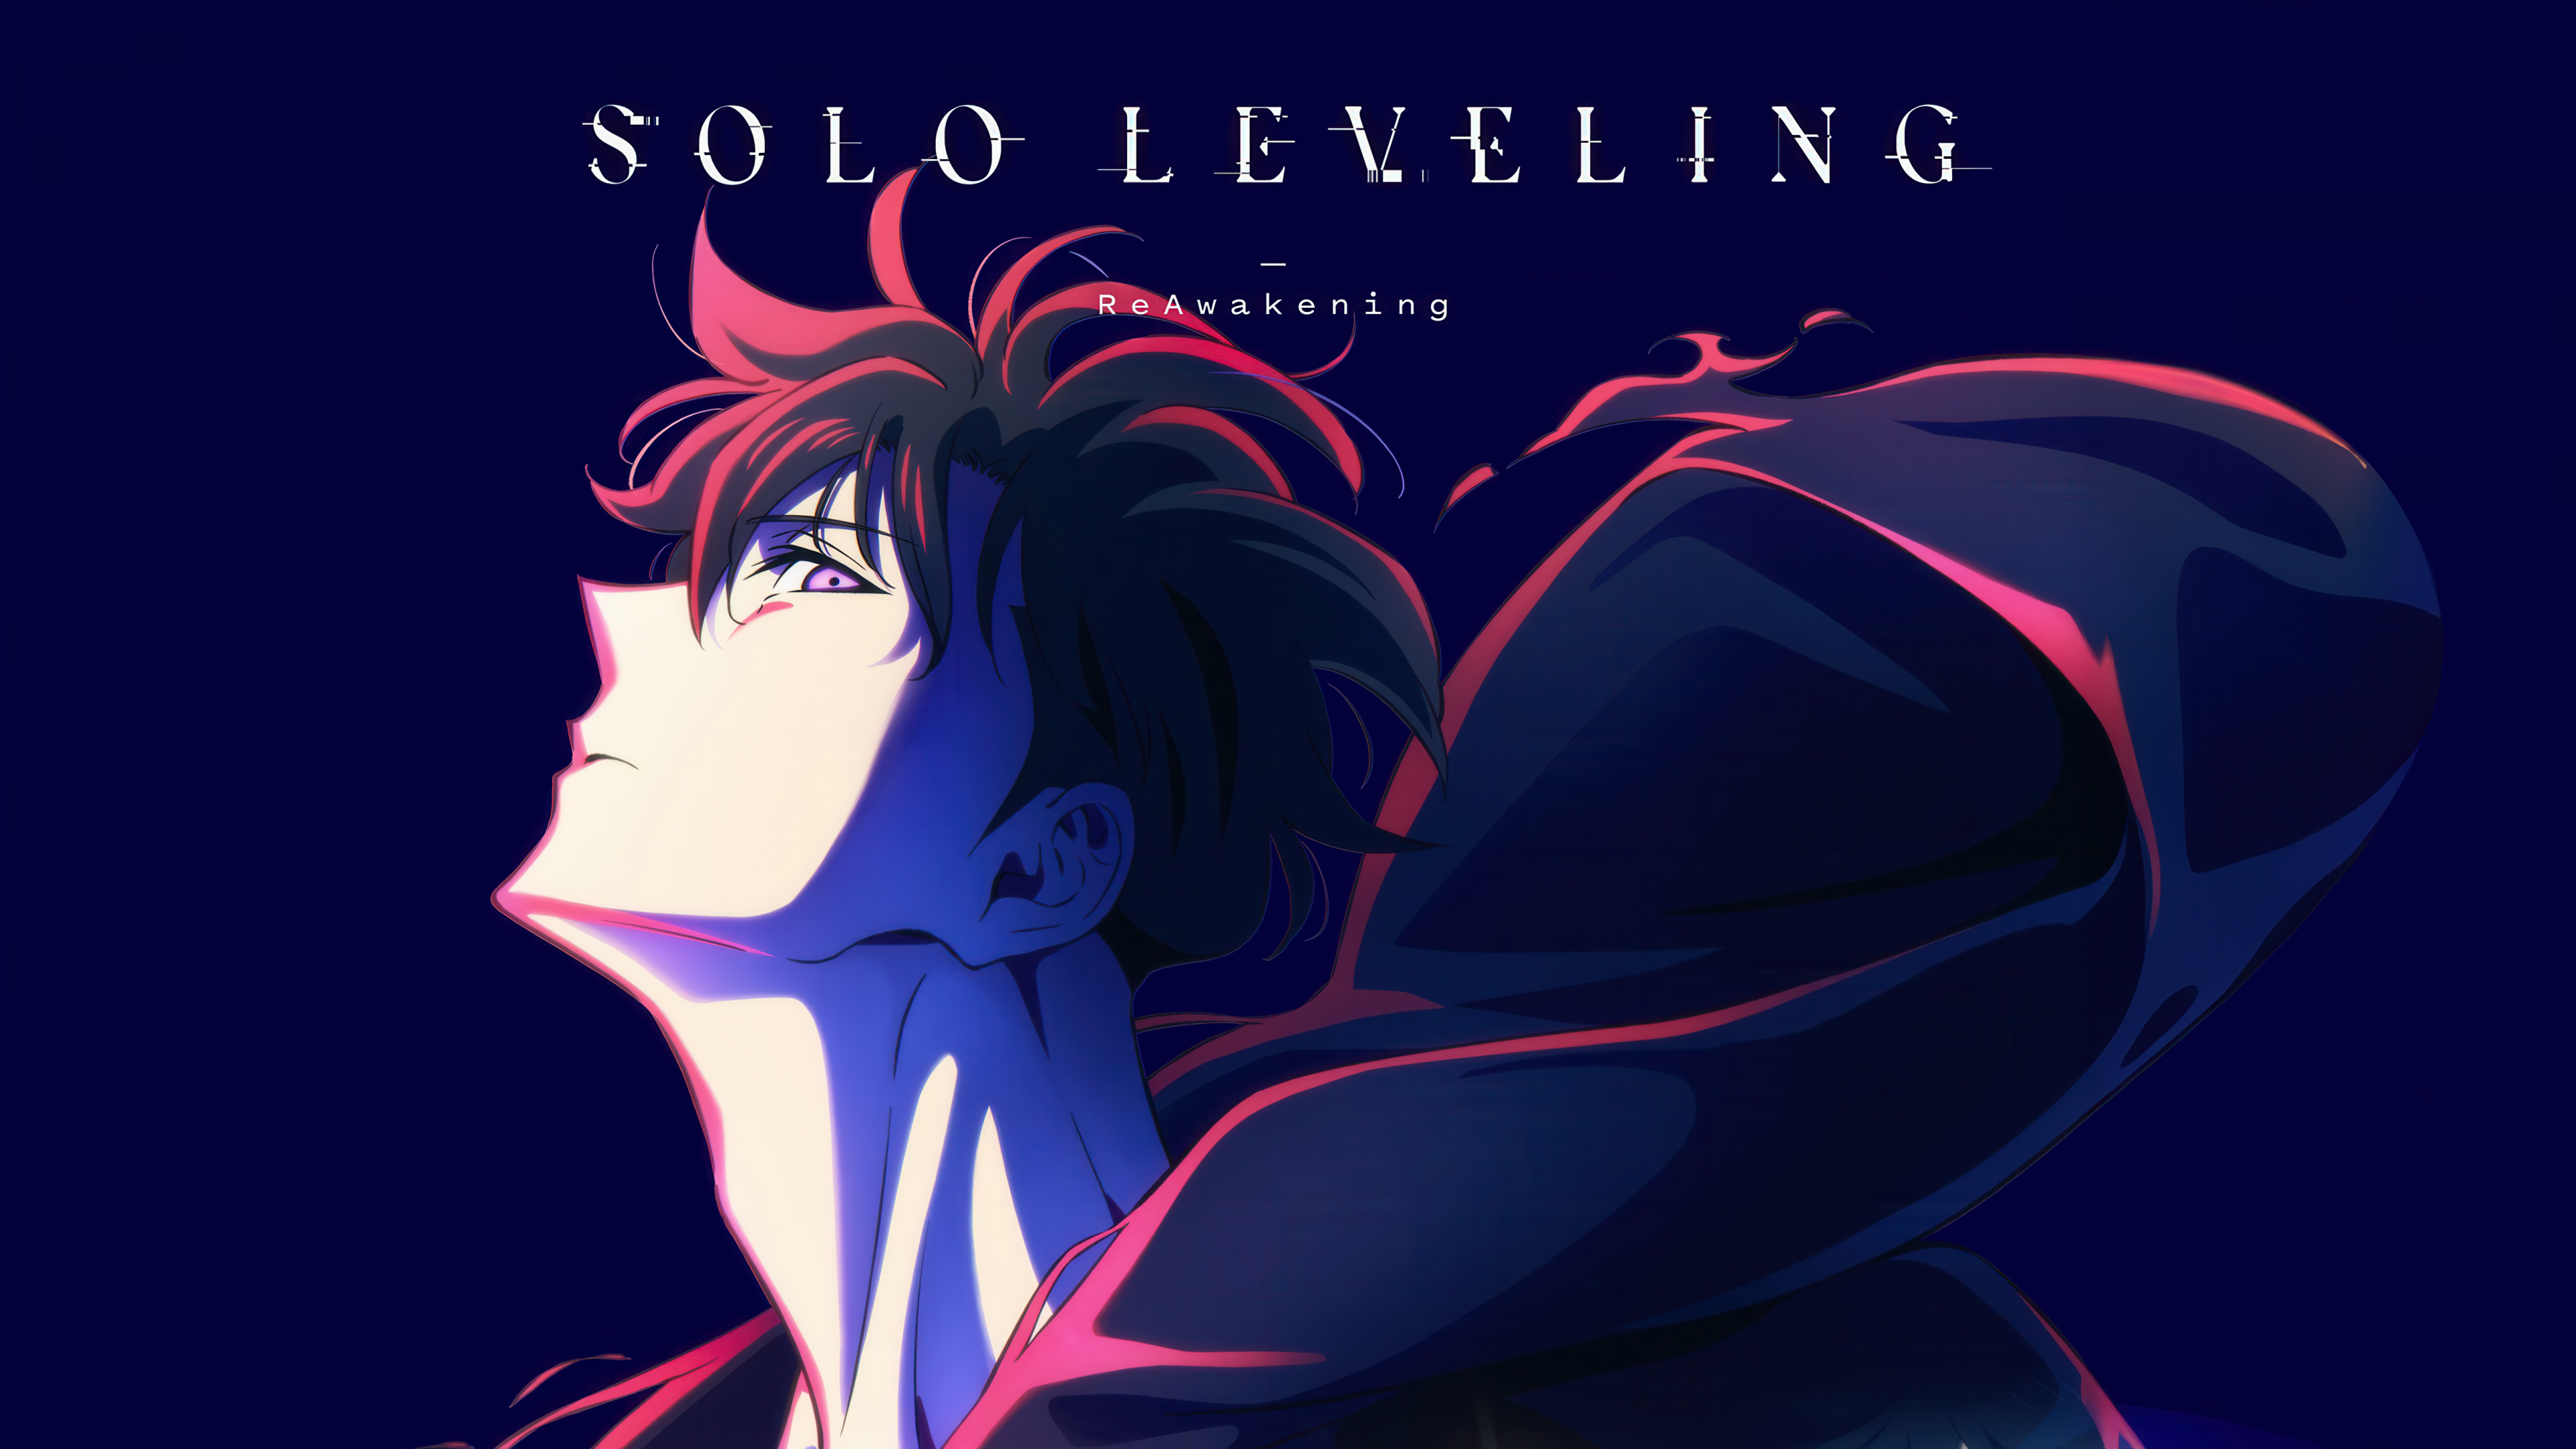

In [17]:
Image("solo-leveling-3840x2160-19518.png")

In [19]:
from datetime import datetime, timedelta
import json
from collections import deque

class DailyMission:
    def __init__(self, name, description, xp_reward, category, required_level=1):
        self.name = name
        self.description = description
        self.xp_reward = xp_reward
        self.category = category
        self.required_level = required_level
        self.completed = False

class Player:
    def __init__(self, name):
        self.name = name
        self.level = 1
        self.last_active = datetime.now().date() - timedelta(days=1)
        self.daily_missions = []
        self.pending_missions_queue = deque()
        self.total_xp = {"strength": 0, "stamina": 0, "willpower": 0}
        self.levels = {"strength": 1, "stamina": 1, "willpower": 1}
        self.generate_daily_missions()

    def generate_daily_missions(self):
        combined_xp = sum(self.total_xp.values())

        if combined_xp >= 200:
            missions = [
                DailyMission("Run", "Run 7 km", 20, "stamina"),
                DailyMission("Push Up", "20 push ups", 20, "strength"),
                DailyMission("Sit Up", "20 sit ups", 20, "strength"),
                DailyMission("Eat Less", "Eat 200 calories less", 20, "willpower"),
                DailyMission("Protein", "Eat 100g protein", 20, "willpower")
            ]
        elif combined_xp >= 100:
            missions = [
                DailyMission("Run", "Run 5 km", 15, "stamina"),
                DailyMission("Push Up", "15 push ups", 15, "strength"),
                DailyMission("Sit Up", "15 sit ups", 15, "strength"),
                DailyMission("Eat Less", "Eat 150 calories less", 15, "willpower"),
                DailyMission("Protein", "Eat 75g protein", 15, "willpower")
            ]
        else:
            missions = [
                DailyMission("Run", "Run 3 km", 10, "stamina"),
                DailyMission("Push Up", "10 push ups", 10, "strength"),
                DailyMission("Sit Up", "10 sit ups", 10, "strength"),
                DailyMission("Eat Less", "Eat 100 calories less", 10, "willpower"),
                DailyMission("Protein", "Eat 50g protein", 10, "willpower")
            ]

        self.daily_missions = missions
        self.pending_missions_queue = deque(missions)

    def refresh_day(self, simulate_new_day=False):
        today = datetime.now().date()
        if simulate_new_day:
            self.last_active = today - timedelta(days=1)

        if today == self.last_active:
            print("\nIt's not a new day yet! Come back tomorrow.")
            return

        self.last_active = today
        self.generate_daily_missions()
        self.save_progress()
        print("\nNew day! New missions await!")

    def complete_mission(self, mission):
        if mission.completed:
            return False

        mission.completed = True
        self.total_xp[mission.category] += mission.xp_reward

        if self.pending_missions_queue and self.pending_missions_queue[0] == mission:
            self.pending_missions_queue.popleft()

        print(f"\nMission complete! +{mission.xp_reward} XP to {mission.category}")

        combined_xp = sum(self.total_xp.values())
        if combined_xp >= 100 and self.level == 1:
            self.level = 2
            print(f"\nPlayer level increased to {self.level}! New missions unlocked!")
            self.generate_daily_missions()

        self.save_progress()
        self.show_missions()
        return True

    def show_missions(self):
        print(f"\n=== DAILY MISSIONS ===")
        print(f"Player: {self.name}")
        print(f"Levels: Strength {self.levels['strength']} | Stamina {self.levels['stamina']} | Willpower {self.levels['willpower']}")
        print(f"XP: Strength {self.total_xp['strength']} | Stamina {self.total_xp['stamina']} | Willpower {self.total_xp['willpower']}\n")

        if not self.daily_missions:
            print("No missions available.")
            self.generate_daily_missions()

        for i, mission in enumerate(self.daily_missions, 1):
            status = "✓" if mission.completed else " "
            print(f"{i}. [{status}] {mission.name}: {mission.description} ({mission.xp_reward} XP)")

    def save_progress(self, filename="progress.json"):
        data = {
            "name": self.name,
            "level": self.level,
            "total_xp": self.total_xp,
            "levels": self.levels,
            "last_active": self.last_active.isoformat()
        }
        with open(filename, "w") as f:
            json.dump(data, f)

    @classmethod
    def load_progress(cls, filename="progress.json"):
        try:
            with open(filename, "r") as f:
                data = json.load(f)
            player = cls(data["name"])
            player.level = data.get("level", 1)
            player.total_xp = data.get("total_xp", {"strength": 0, "stamina": 0, "willpower": 0})
            player.levels = data.get("levels", {"strength": 1, "stamina": 1, "willpower": 1})
            player.last_active = datetime.fromisoformat(data["last_active"]).date()
            player.generate_daily_missions()
            return player
        except FileNotFoundError:
            return None

def main():
    print("Notification!")
    print("\n=== Welcome to Soloing Leveling System ===")
    print("You have acquired the qualifications to be a Player.")
    choice = input("Will you accept? (Y/N): ").strip().upper()

    if choice != 'Y':
        print("The quest awaits when you're ready...")
        return

    player = Player.load_progress()
    if player:
        print(f"\nWelcome back, {player.name}!")
    else:
        player = Player("Player")
        player.save_progress()
        print("\n[You've become a Player]")
        print("\n[Daily Quest has arrived]")

    while True:
        player.show_missions()
        print("\nOptions:")
        print("1. Complete next mission")
        print("2. Start new day (refresh missions)")
        print("3. Exit")

        choice = input("\nSelect an option (1-3): ").strip()

        if choice == "1":
            if not player.pending_missions_queue:
                print("\nAll missions completed for today! Great job!")
                continue

            next_mission = player.pending_missions_queue[0]
            player.complete_mission(next_mission)

            if not player.pending_missions_queue:
                print("\nAll missions completed for today! Great job!")

        elif choice == "2":
            player.refresh_day(simulate_new_day=True)

        elif choice == "3":
            print("\nGoodbye! Keep up the good work!")
            break

        else:
            print("\nInvalid choice. Please select 1, 2, or 3")

        input("\nPress Enter to continue...")

if __name__ == "__main__":
    main()


Notification!

=== Welcome to Soloing Leveling System ===
You have acquired the qualifications to be a Player.
Will you accept? (Y/N): y

Welcome back, Player!

=== DAILY MISSIONS (Level 1) ===
Player: Player
Levels: Strength 2 | Stamina 1 | Willpower 2
XP: Strength 140 | Stamina 70 | Willpower 140

1. [ ] Run: Run 7 km (20 XP)
2. [ ] Push Up: 20 push ups (20 XP)
3. [ ] Sit Up: 20 sit ups (20 XP)
4. [ ] Eat Less: Eat 200 calories less (20 XP)
5. [ ] Protein: Eat 100g protein (20 XP)

Options:
1. Complete next mission
2. Start new day (refresh missions)
3. Exit

Select an option (1-3): 3

Goodbye! Keep up the good work!


Time and Space COmpelxity is 0(1) and constant if we want to add more missions, goals and player data, it could change to something like O(n)